In [1]:
import numpy as np
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

from keras.applications import VGG19

import cv2

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
import pretrained_model_custom_image_preprocessing as cip

In [11]:
vgg = VGG19(include_top=False)

In [12]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [13]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(3, activation='softmax')(x)
model = Model(vgg.input, predictions)
model

In [14]:
# train just the custom layers
for layer in vgg.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
batch_size = 8

# subtract vgg mean from each image
# apply vgg mean to data generator
gen = ImageDataGenerator(featurewise_center=True)
cip.apply_vgg_mean(gen)

In [15]:
train_generator = gen.flow_from_directory(
        'data/subset/train/',  # this is the target directory
        target_size=(224, 224),  # made my images this size
        batch_size=batch_size,
        class_mode='categorical')  

validation_generator = gen.flow_from_directory(
        'data/subset/test/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

model.fit_generator(
        train_generator,
        steps_per_epoch=3000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=600 // batch_size)

Found 300 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Epoch 1/5
37/37 [==============================] - 331s - loss: 0.8832 - acc: 0.7635 - val_loss: 0.6372 - val_acc: 0.9821
Epoch 2/5
37/37 [==============================] - 324s - loss: 0.4985 - acc: 0.9730 - val_loss: 0.3898 - val_acc: 0.9808
Epoch 3/5
37/37 [==============================] - 325s - loss: 0.3102 - acc: 0.9899 - val_loss: 0.3049 - val_acc: 0.9231
Epoch 4/5
37/37 [==============================] - 322s - loss: 0.2176 - acc: 0.9865 - val_loss: 0.1978 - val_acc: 0.9423
Epoch 5/5
37/37 [==============================] - 331s - loss: 0.1577 - acc: 0.9899 - val_loss: 0.1714 - val_acc: 0.9615


In [16]:
model.save('VGG19_trained.h5')

In [17]:
model.save_weights('VGG19_weights.h5')

In [ ]:
batch_size = 16

def rgb_to_bgr(im):
    return im[:,:,::-1]

# subtract vgg mean from each image
# apply vgg mean to data generator
gen = ImageDataGenerator(featurewise_center=True, preprocessing_function=rgb_to_bgr)
gen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape((1, 1, 3))

cip.apply_vgg_mean(gen)

In [14]:
im[:,2]

array([226, 218, 202, 188, 183, 181, 185, 178, 169, 164, 169, 176, 183,
       194, 200, 215, 211, 185, 172, 179, 187, 182, 182, 171, 160, 162,
       174, 191, 199, 217, 229, 213, 220, 192, 190, 194, 193, 197, 184,
       166, 166, 180, 189, 190, 191, 190, 191, 209, 185, 175, 195, 212,
       216, 210, 198, 170, 177, 191, 185, 180, 197, 204, 182, 171, 185,
       200, 184, 172, 181, 189, 178, 180, 187, 173, 165, 185, 172, 153,
       174, 171, 187, 183, 179, 171, 166, 183, 191, 182, 169, 172, 186,
       190, 172, 160, 167, 175, 172, 189, 194, 178, 158, 156, 164, 176,
       188, 184, 170, 159, 159, 161, 158, 140, 166, 161, 167, 173, 185,
       169, 147, 152, 159, 165, 145, 156, 181, 187, 166, 172, 184, 191,
       191, 174, 170, 198, 204, 184, 168, 163, 158, 148, 150, 158, 158,
       137, 131, 160, 180, 185, 183, 178, 196, 190, 188, 183, 166, 178,
       178, 156, 170, 180, 170, 174, 187, 186, 180, 197, 211, 228, 218,
       234, 227, 195, 188, 191, 166, 178, 178, 166, 172, 203, 20

In [19]:
from CAM import get_multi_stacked_cam, predict_label_with_cam

[  1.62941342e-05   2.48435279e-03   9.97499287e-01]


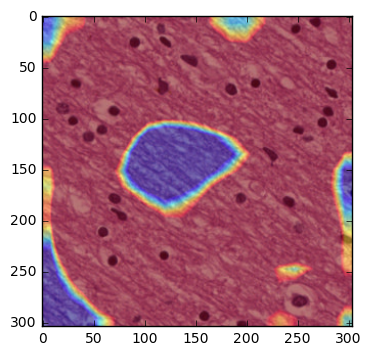

In [28]:
cam, pred = predict_label_with_cam(model, IMAGE, -4, -1 ,overlay=True)
print(pred)
plt.imshow(cam)

[  1.62941342e-05   2.48435279e-03   9.97499287e-01] ['blank', 'gray', 'white']
{'blank': [1.6294134e-05, 'Greens'], 'white': [0.99749929, 'Reds'], 'gray': [0.0024843528, 'Blues']}


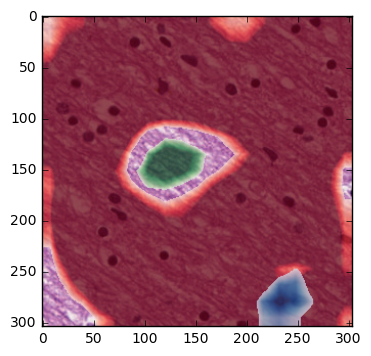

In [29]:
cam, pred = get_multi_stacked_cam(model, 'BrainWhiteMatter.jpg', ['blank', 'gray', 'white'], -4, show_top_x_classes=3)
print(pred)
plt.imshow(cam)

In [23]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

# we chose to train the top 3 blocks
for layer in model.layers[:18]:
    layer.trainable = False
for layer in model.layers[18:]:
    layer.trainable = True

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_1
23 dense_1


In [24]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 3 conv blocks
# alongside the top Dense layers
model.fit_generator(
        train_generator,
        steps_per_epoch=3000 // batch_size,
        epochs=8,
        validation_data=validation_generator,
        validation_steps=600 // batch_size)

Epoch 1/8
37/37 [==============================] - 340s - loss: 0.0852 - acc: 1.0000 - val_loss: 0.1717 - val_acc: 0.9038
Epoch 2/8
37/37 [==============================] - 344s - loss: 0.0388 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 0.9808
Epoch 3/8
37/37 [==============================] - 358s - loss: 0.0198 - acc: 1.0000 - val_loss: 0.1083 - val_acc: 0.9423
Epoch 4/8
37/37 [==============================] - 355s - loss: 0.0133 - acc: 1.0000 - val_loss: 0.0481 - val_acc: 0.9821
Epoch 5/8
37/37 [==============================] - 363s - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0877 - val_acc: 0.9615
Epoch 6/8
37/37 [==============================] - 376s - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0631 - val_acc: 0.9808
Epoch 7/8
37/37 [==============================] - 371s - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0717 - val_acc: 0.9615
Epoch 8/8
37/37 [==============================] - 363s - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0707 - val_acc: 0.9615


In [25]:
model.save('VGG19_trained.h5')
model.save_weights('VGG19_weights.h5')

## how our model looks like

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________